# XGB test


In [1]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

In [85]:
import pandas as pd

import seaborn as sns

from math import log

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from xgboost import XGBRegressor
import shap


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import linregress

from plots2.fns import (
    # standard_layout,
    # corner_annotations_colwise,
    # corner_annotations_rowwise,
    # get_text_annotation,
    get_corner_annotations,
    get_corner_annotations_custom_labels,
    # get_corner_annotations_explicit
)

from plots2.consts import (
    SMALL_FONT,
    MEDIUM_FONT,
    BIGGER_FONT,
    SHAP_BLUE
)

from poly2.utils import trait_vec, gamma_dist, object_dump, object_load
# from poly2.shap import get_shap_values_cumulative
# from poly2.run import no_joblib_single_run, no_joblib_multiple_run
from poly2.config import Config, ConfigMixture, get_asymptote_config
# from poly2.simulator import SimulatorOneTrait, SimulatorAsymptote

In [5]:
df = pd.read_csv('../outputs/combined/scan_all.csv')

df.head()

,run,year,best_dose,n_pos_diff,in_0p0_0p1,in_0p1_0p2,in_0p2_0p3,in_0p3_0p4,in_0p4_0p5,in_0p5_0p6,...,in_0p8_0p9,in_0p9_1p0,mu,b,asymptote,dec_rate_multiplier,m_prop_multiplier,m_scale_multiplier,ME_var,ME_mean
0,0,1,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241
1,0,2,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241
2,0,3,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241
3,0,4,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241
4,0,5,1.0,9,1.0,5.054079e-27,7.584700e-34,1.472094e-39,4.846678e-45,9.976588e-51,...,2.492945e-74,3.501367e-90,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,5.044122e-17,0.398241


In [6]:
X = (
    df
    .drop([
        'best_dose',
        'n_pos_diff',
        'ME_var',
    ], axis=1)
    .filter(regex='^((?!in_0).)*$')
    .rename(columns = {
        'dec_rate_multiplier': 'dec_rate',
        'm_prop_multiplier': 'm_prop',
        'm_scale_multiplier': 'm_scale',
        'asymptote': 'asymp',
    })
)

y = df.loc[:, ['run', 'best_dose']]

X.head()

,run,year,mu,b,asymp,dec_rate,m_prop,m_scale,ME_mean
0,0,1,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
1,0,2,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
2,0,3,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
3,0,4,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241
4,0,5,17.879734,2.744068,0.602763,1.786355,0.703574,1.95789,0.398241


In [22]:
# reset index? Might help with Int64Index XGB warning
X_cv = X.loc[lambda x: (x.run<8000)].drop('run', axis=1)
y_cv = y.loc[lambda x: (x.run<8000)].drop('run', axis=1)

X_test = X.loc[lambda x: (x.run>=8000)].drop('run', axis=1)
y_test = np.array(y.loc[lambda x: (x.run>=8000)].drop('run', axis=1))[:, 0]

# Basic linear

In [39]:
model = LinearRegression().fit(X_cv, y_cv)

In [40]:
yp = model.predict(X_test)[:, 0]

In [41]:
res = pd.DataFrame(dict(
    linear_model = yp,
    data = y_test
))

<AxesSubplot:xlabel='data', ylabel='linear_model'>

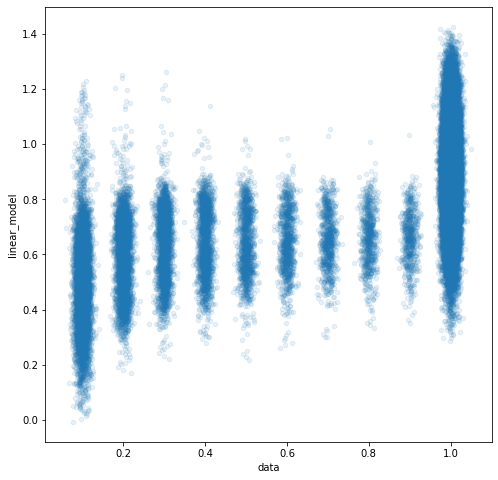

In [58]:
f, ax = plt.subplots(figsize=(8,8))

(
    res
    .assign(data = lambda x: x.data + np.random.normal(0, 0.01, x.shape[0]))
    .plot
    .scatter(
        x='data',
        y='linear_model', 
        alpha=0.1, 
        ax=ax
    )
)

# Polynomial regression with interactions

In [111]:
interaction = PolynomialFeatures(degree=4, include_bias=False, interaction_only=True)
X_inter = interaction.fit_transform(X_cv)

In [112]:
Xt_inter = interaction.fit_transform(X_test)

In [113]:
regr = LinearRegression()
model2 = regr.fit(X_inter, y_cv)

In [114]:
yp2 = model2.predict(Xt_inter)[:, 0]

In [115]:
res = res.assign(interactions = yp2)

<AxesSubplot:xlabel='data', ylabel='interactions'>

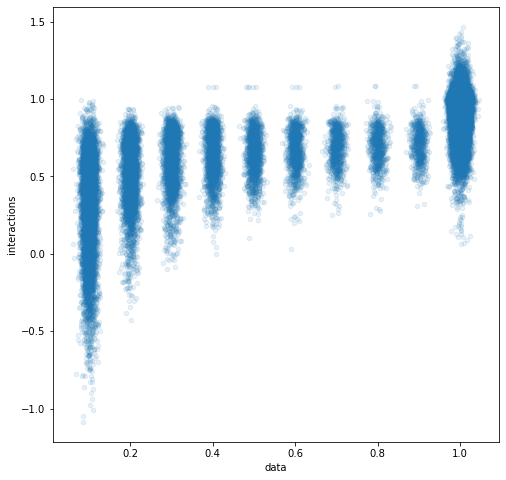

In [116]:
f, ax = plt.subplots(figsize=(8,8))

(
    res
    .assign(data = lambda x: x.data + np.random.normal(0, 0.01, x.shape[0]))
    .plot
    .scatter(
        x='data',
        y='interactions', 
        alpha=0.1, 
        ax=ax
    )
)

# R squared values

In [117]:
_, _, r_value, _, _ = linregress(res.data, res.linear_model)

r_value**2

0.4254089547991153

In [118]:
_, _, r_value, _, _ = linregress(res.data, res.interactions)

r_value**2

0.6173528305514959